# **UIT2521 - SOFTWARE DEVELOPMENT PROJECT**

# ***GUAVA PLANT DISEASE CLASSIFICATION AND PREDICTION***

#**DONE BY:**

#R.NITHYASRI -REG NO: 3122 22 5002 086
#R.NITISH -   REG NO: 3122 22 5002 088


#GUIDED BY: Dr.Durga Devi, ASP, DEPARTMENT OF IT
#Dr.A.Saravanan, ASP, DEPARTMENT OF IT


#-------------------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------



**## SECTION 1: Mounting Google Drive and its required folders, along with the required packages for machine learning.**

This setup ensures that the Drive data is accessible and the necessary packages are ready to use for processing and analyzing the image data.

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from PIL import Image
from google.colab import drive
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
class DriveManager:
    """Handles Google Drive mounting and folder setup."""

    @staticmethod
    def mount_drive():
        drive.mount('/content/drive')
        print("Google Drive mounted.")

    @staticmethod
    def get_paths():
        paths = {
            "leaf_healthy": '/content/drive/MyDrive/SDP_Project_Dataset/Leaf_Disease_Dataset/Disease Free',
            "leaf_disease": '/content/drive/MyDrive/SDP_Project_Dataset/Leaf_Disease_Dataset',
            "leaf_disease_infected": '/content/drive/MyDrive/SDP_Project_Dataset/Leaf_Disease_Dataset/Red rust',
            "fruit_disease_phytopthora": '/content/drive/MyDrive/SDP_Project_Dataset/Fruit_Disease_Dataset/Phytopthora',
            "fruit_disease_root": '/content/drive/MyDrive/SDP_Project_Dataset/Fruit_Disease_Dataset/Root',
            "fruit_disease_scab":'/content/drive/MyDrive/SDP_Project_Dataset/Fruit_Disease_Dataset/Scab'
        }
        return paths


SECTION 2: Data Loading and Preprocessing - Performing Image Augmentation and Classification of Training and Test Datasets

In [ ]:
class DataLoader:
    """Loads and preprocesses data, applying augmentations."""

    def __init__(self, leaf_disease_free, leaf_disease_infected):
        self.leaf_disease_free = leaf_disease_free
        self.leaf_disease_infected = leaf_disease_infected

    def process_and_extract_rgb(self, folder_path, label, target_size=(128, 128), augment=False):
        features, labels = [], []
        datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2,
                                     height_shift_range=0.2, shear_range=0.15, horizontal_flip=True,
                                     brightness_range=[0.8, 1.2])

        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            if image is None:
                continue
            image_resized = cv2.resize(image, target_size)
            if augment:
                image_expanded = np.expand_dims(image_resized, axis=0)
                aug_iter = datagen.flow(image_expanded)
                image_resized = aug_iter[0].astype(np.uint8)
            r_mean, g_mean, b_mean = np.mean(image_resized[:, :, 0]), np.mean(image_resized[:, :, 1]), np.mean(image_resized[:, :, 2])
            features.append([r_mean, g_mean, b_mean])
            labels.append(label)
        return features, labels

    def load_data(self):
        free_features, free_labels = self.process_and_extract_rgb(self.leaf_disease_free, label=0, augment=True)
        infected_features, infected_labels = self.process_and_extract_rgb(self.leaf_disease_infected, label=1, augment=True)
        features, labels = free_features + infected_features, free_labels + infected_labels
        X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
        return X_train, X_test, y_train, y_test




SECTION 3: DATA DESCRIPTION - LEAF DISEASE CLASSIFICATION


In [ ]:
class LeafDataDescriptor:
    def __init__(self, disease1_folder, disease2_folder):
        self.disease1_folder = disease1_folder
        self.disease2_folder = disease2_folder
        self.class_counts_disease1 = defaultdict(int)
        self.class_counts_disease2 = defaultdict(int)
        self.dimensions_disease1 = []
        self.dimensions_disease2 = []

    def process_images(self):
        """Process images for both diseases."""
        self._process_disease_images(self.disease1_folder, self.class_counts_disease1, self.dimensions_disease1)
        self._process_disease_images(self.disease2_folder, self.class_counts_disease2, self.dimensions_disease2)

    def _process_disease_images(self, folder, class_counts, dimensions):
        """Helper method to process images for a specific disease."""
        for root, dirs, files in os.walk(folder):
            for file in files:
                class_name = os.path.basename(root)
                class_counts[class_name] += 1
                img_path = os.path.join(root, file)

                try:
                    with Image.open(img_path) as img:
                        dimensions.append(img.size)
                except FileNotFoundError:
                    print(f"Warning: File '{img_path}' not found.")
                except Exception as e:
                    print(f"Error opening image '{img_path}': {e}")

    def print_class_counts(self):
        """Print the class counts for both diseases."""
        print("Class counts for Disease 1:")
        for class_name, count in self.class_counts_disease1.items():
            print(f"Class '{class_name}' : {count} images")

        print("\nClass counts for Disease 2:")
        for class_name, count in self.class_counts_disease2.items():
            print(f"Class '{class_name}' : {count} images")

    def calculate_average_dimensions(self):
        """Calculate and print the average image dimensions for both diseases."""
        avg_width_1, avg_height_1 = self._calculate_average_dimensions(self.dimensions_disease1)
        avg_width_2, avg_height_2 = self._calculate_average_dimensions(self.dimensions_disease2)

        print(f'\nAverage Image Dimension (Disease 1): {avg_width_1}x{avg_height_1}')
        print(f'Average Image Dimension (Disease 2): {avg_width_2}x{avg_height_2}')

    def _calculate_average_dimensions(self, dimensions):
        """Helper method to calculate average dimensions."""
        widths, heights = zip(*dimensions) if dimensions else ([], [])
        avg_width = sum(widths) / len(widths) if widths else 0
        avg_height = sum(heights) / len(heights) if heights else 0
        return avg_width, avg_height

    def display_sample_images(self, num_images=5):
        """Display the first few sample images from both diseases."""
        self._display_sample_images_from_folder(self.disease1_folder, num_images, "Disease 1")
        self._display_sample_images_from_folder(self.disease2_folder, num_images, "Disease 2")

    def _display_sample_images_from_folder(self, folder, num_images, disease_name):
        """Helper method to display sample images from a folder."""
        image_files = os.listdir(folder)
        print(f"\nDisplaying first {num_images} images from {disease_name}...")
        for i, image_file in enumerate(image_files[:num_images]):
            img_path = os.path.join(folder, image_file)
            try:
                with Image.open(img_path) as img:
                    plt.imshow(img)
                    plt.figure(figsize=(14, 14))
                    plt.show()
            except FileNotFoundError:
                print(f"Warning: Image '{img_path}' not found.")
            except Exception as e:
                print(f"Error opening image '{img_path}': {e}")


SECTION 4: DEVELOPMENT OF A DISEASE CLASSIFIER FOR THE

In [ ]:
class LeafDiseaseClassifier:
    """Defines and trains models including CNN for classification of leaf diseases"""

    def __init__(self, input_shape=(128, 128, 3), num_classes=2, model_type='cnn'):
        """
        Initializes the classifier.

        Args:
            input_shape: Shape of input images.
            num_classes: Number of output classes (e.g., 2 for binary classification).
        """
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model =self.build_cnn()


    def build_cnn(self):
        """Builds a simple CNN model."""
        model = Sequential()
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.num_classes, activation='softmax'))  # softmax for multi-class classification

        model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def train(self, train_generator, validation_generator, epochs=25):
        """Trains the current model (CNN, ResNet50, or VGG16) with the provided generators."""
        if self.model is None:
            raise ValueError("No model is defined. Please build a model first.")
        history = self.model.fit(train_generator, validation_data=validation_generator, epochs=epochs)
        return history

    def evaluate(self, validation_generator):
        """Evaluates the model on the validation set."""
        val_loss, val_accuracy = self.model.evaluate(validation_generator)
        print(f'Validation Loss: {val_loss}\nValidation Accuracy: {val_accuracy}')
        return val_loss, val_accuracy

    def plot_training_history(self, history):
        """
        Plots the training and validation accuracy and loss.

        Args:
            history: History object returned by the fit method.
        """
        plt.figure(figsize=(12, 4))

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Training and Validation Accuracy')

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')

        plt.show()

    def classification_report(self, validation_generator):
        """
        Prints the classification report and confusion matrix.

        Args:
            validation_generator (ImageDataGenerator): Generator for validation data.
        """
        y_true = validation_generator.classes
        y_pred = np.argmax(self.model.predict(validation_generator), axis=-1)

        # Classification report
        print("Classification Report:\n", classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys()))

        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()





In [ ]:
class FruitDiseaseClassifier:
    """CNN-based model for multi-class classification of plant diseases."""

    def __init__(self, input_shape=(224, 224, 3), num_classes=3):
        """
        Initializes the CNN-based multi-disease classifier.

        Args:
            input_shape (tuple): Shape of the input images.
            num_classes (int): Number of disease classes.
        """
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_cnn_model()

    def build_cnn_model(self):
        """Builds a CNN model with custom layers."""
        model = Sequential()

        # Convolutional layers with Batch Normalization and MaxPooling
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(256, (3, 3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # Fully connected layers
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def train(self, train_generator, validation_generator, epochs=20):
        """
        Trains the model with the provided data generators.

        Args:
            train_generator (ImageDataGenerator): Generator for training data.
            validation_generator (ImageDataGenerator): Generator for validation data.
            epochs (int): Number of training epochs.
        """
        history = self.model.fit(train_generator, validation_data=validation_generator, epochs=epochs)
        return history

    def evaluate(self, validation_generator):
        """
        Evaluates the model on the validation set.

        Args:
            validation_generator (ImageDataGenerator): Generator for validation data.

        Returns:
            Tuple of validation loss and accuracy.
        """
        val_loss, val_accuracy = self.model.evaluate(validation_generator)
        print(f'Validation Loss: {val_loss}\nValidation Accuracy: {val_accuracy}')
        return val_loss, val_accuracy

    def plot_training_history(self, history):
        """
        Plots the training and validation accuracy and loss.

        Args:
            history: History object returned by the fit method.
        """
        plt.figure(figsize=(12, 4))

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Training and Validation Accuracy')

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')

        plt.show()

    def classification_report(self, validation_generator):
        """
        Prints the classification report and confusion matrix.

        Args:
            validation_generator (ImageDataGenerator): Generator for validation data.
        """
        y_true = validation_generator.classes
        y_pred = np.argmax(self.model.predict(validation_generator), axis=-1)

        # Classification report
        print("Classification Report:\n", classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys()))

        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()


In [ ]:
class Visualizer:
    """Plots training progress and visualizes sample images."""

    @staticmethod
    def plot_training_history(history):
        plt.plot(history.history['accuracy'], label='train_accuracy')
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label='train_loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    @staticmethod
    def show_images(folder_path, num_images=5):
        image_files = os.listdir(folder_path)[:num_images]
        for image_file in image_files:
            img_path = os.path.join(folder_path, image_file)
            try:
                with Image.open(img_path) as img:
                    plt.imshow(img)
                    plt.figure(figsize=(5, 5))
                    plt.show()
            except Exception as e:
                print(f"Error opening image '{img_path}': {e}")




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted.
Class counts for Disease 1:
Class 'Disease Free' : 126 images

Class counts for Disease 2:
Class 'Red rust' : 87 images

Average Image Dimension (Disease 1): 1102.563492063492x1229.1904761904761
Average Image Dimension (Disease 2): 806.080459770115x931.9770114942529

Displaying first 5 images from Disease 1...


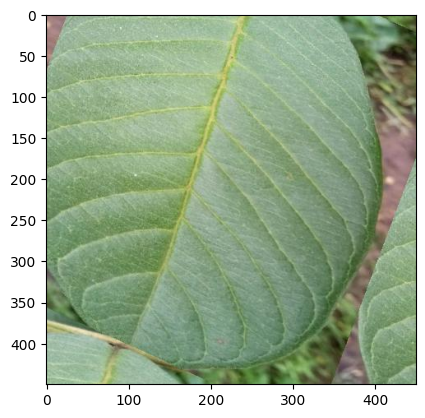

<Figure size 1400x1400 with 0 Axes>

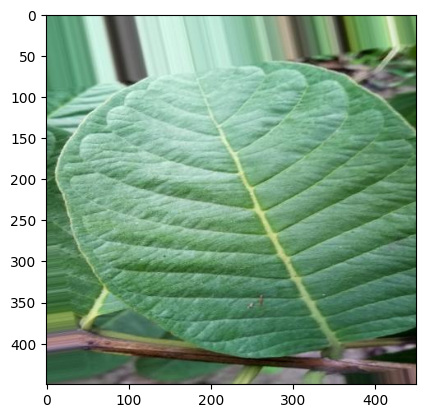

<Figure size 1400x1400 with 0 Axes>

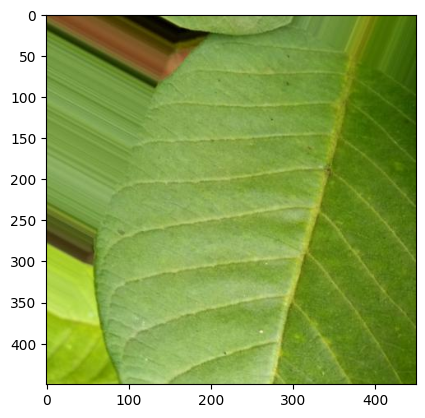

<Figure size 1400x1400 with 0 Axes>

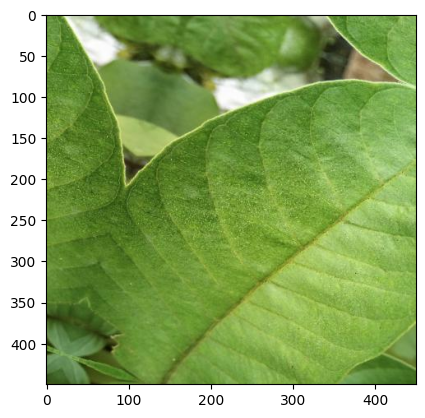

<Figure size 1400x1400 with 0 Axes>

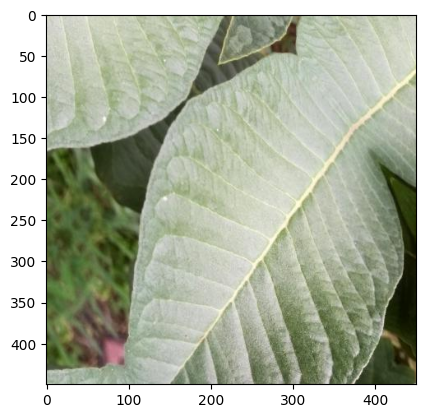

<Figure size 1400x1400 with 0 Axes>


Displaying first 5 images from Disease 2...


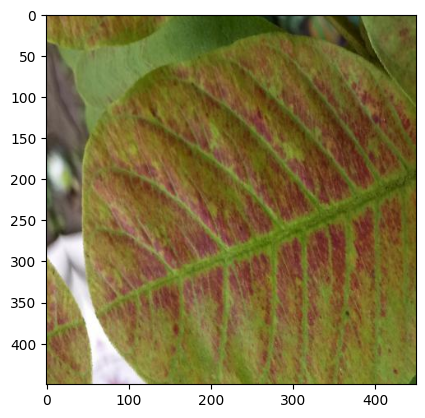

<Figure size 1400x1400 with 0 Axes>

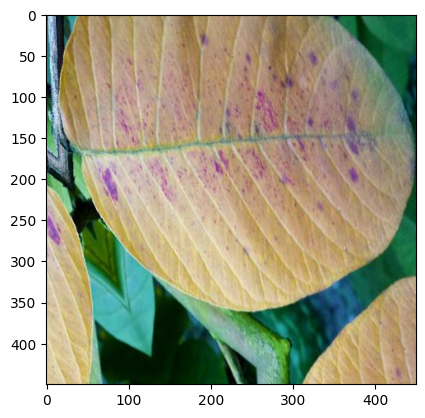

<Figure size 1400x1400 with 0 Axes>

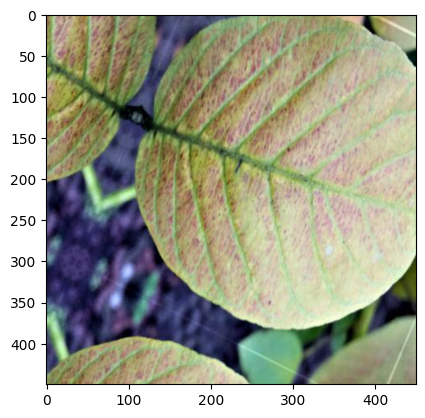

<Figure size 1400x1400 with 0 Axes>

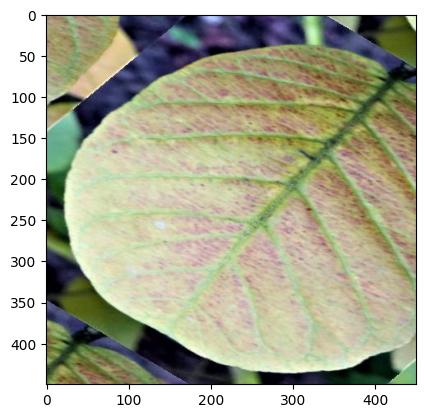

<Figure size 1400x1400 with 0 Axes>

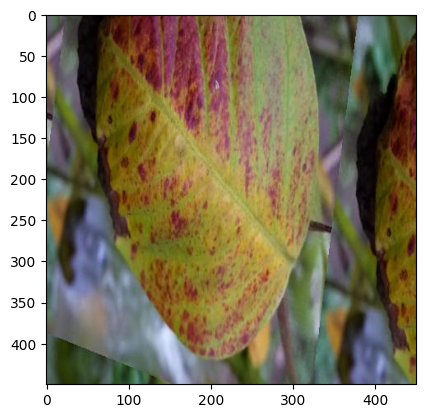

<Figure size 1400x1400 with 0 Axes>

Found 171 images belonging to 2 classes.
Found 42 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5367 - loss: 0.6909 - val_accuracy: 0.7143 - val_loss: 0.6037
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7302 - loss: 0.5819 - val_accuracy: 0.7857 - val_loss: 0.4760
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8621 - loss: 0.4489 - val_accuracy: 0.9286 - val_loss: 0.3927
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9604 - loss: 0.3349 - val_accuracy: 0.9762 - val_loss: 0.2923
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9580 - loss: 0.2238 - val_accuracy: 1.0000 - val_loss: 0.1902
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 1.0000 - loss: 0.1692 - val_accuracy: 0.9286 - val_loss: 0.1750
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9702 - loss: 0.1262 - val_accuracy: 1.0000 - val_loss: 0.0900
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9730 - loss: 0.0970 - val_accuracy: 0.9524 - val_loss: 0.1237
Epoch 9/10
6/6 ━━━━━

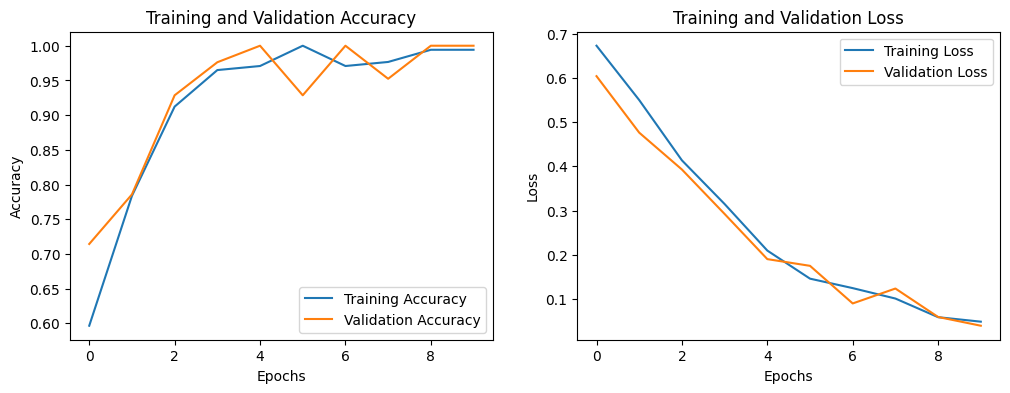

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step
Classification Report:
               precision    recall  f1-score   support

Disease Free       0.60      0.60      0.60        25
    Red rust       0.41      0.41      0.41        17

    accuracy                           0.52        42
   macro avg       0.51      0.51      0.51        42
weighted avg       0.52      0.52      0.52        42



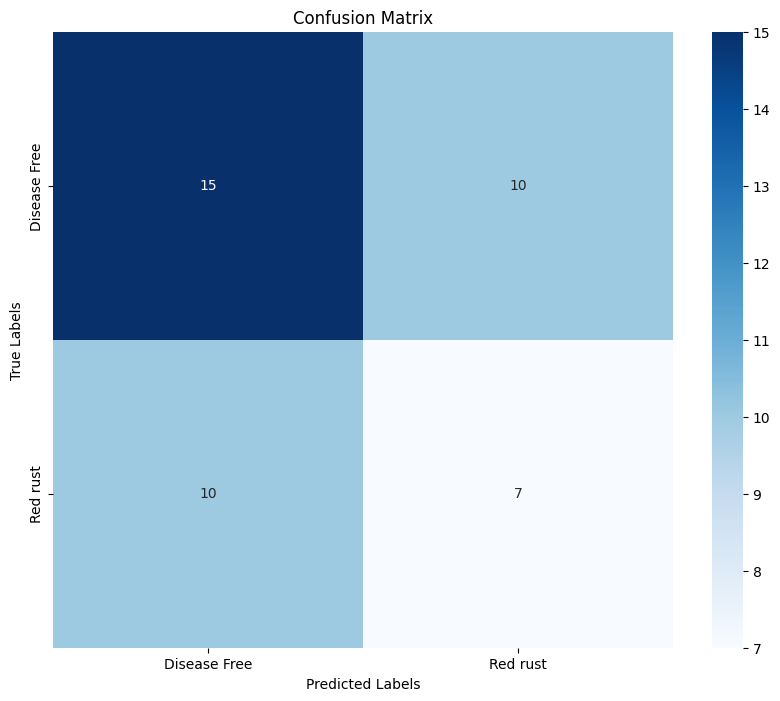

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DriveManager.mount_drive()
paths = DriveManager.get_paths()

data_loader = DataLoader(paths["leaf_healthy"], paths["leaf_disease_infected"])
X_train, X_test, y_train, y_test = data_loader.load_data()

descriptor = LeafDataDescriptor(paths['leaf_healthy'], paths['leaf_disease_infected'])

descriptor.process_images()

descriptor.print_class_counts()

descriptor.calculate_average_dimensions()

descriptor.display_sample_images(num_images=5)

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(paths["leaf_disease"], target_size=(128, 128),
                                                    batch_size=32, class_mode='categorical', subset='training')
validation_generator = train_datagen.flow_from_directory(paths["leaf_disease"], target_size=(128, 128),
                                                         batch_size=32, class_mode='categorical', subset='validation')


input_shape = (128, 128, 3)
num_classes = len(train_generator.class_indices)
leaf_classifier = LeafDiseaseClassifier(input_shape=input_shape, num_classes=num_classes)
model = leaf_classifier.model
plot_model(model, to_file="cnn_model.png", show_shapes=True, show_layer_names=True)

# Build and train the model (You can choose any model)

history = leaf_classifier.train(train_generator, validation_generator, epochs=10)

# Evaluate the model
leaf_classifier.evaluate(validation_generator)

# Plot training history
leaf_classifier.plot_training_history(history)

# Display classification report and confusion matrix
leaf_classifier.classification_report(validation_generator)




Found 416 images belonging to 3 classes.
Found 416 images belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 187s 9s/step - accuracy: 0.4981 - loss: 2.2650 - val_accuracy: 0.3365 - val_loss: 1.1983
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 142s 9s/step - accuracy: 0.7672 - loss: 1.2082 - val_accuracy: 0.3365 - val_loss: 1.2259
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 142s 9s/step - accuracy: 0.8247 - loss: 0.7720 - val_accuracy: 0.3365 - val_loss: 1.4576
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 122s 9s/step - accuracy: 0.8290 - loss: 0.5993 - val_accuracy: 0.3365 - val_loss: 1.7858
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 140s 11s/step - accuracy: 0.8991 - loss: 0.3374 - val_accuracy: 0.3365 - val_loss: 1.6044
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.3830 - loss: 1.5234
Validation Loss: 1.6043702363967896
Validation Accuracy: 0.3365384638309479


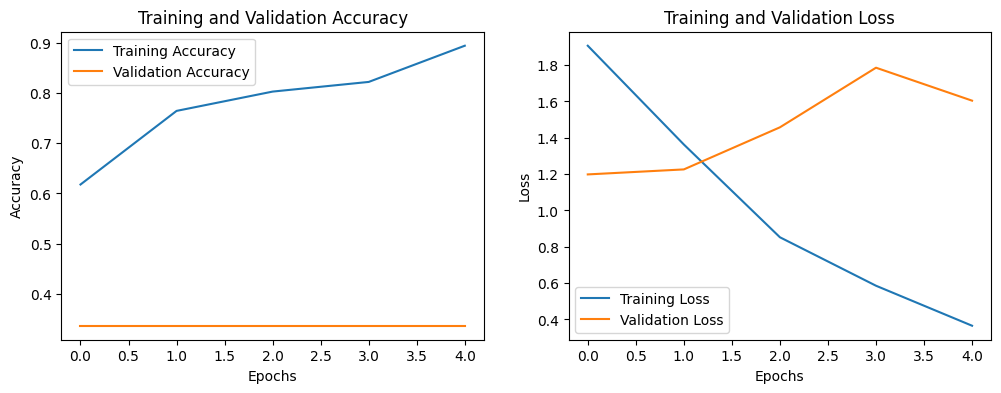

13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step
Classification Report:
               precision    recall  f1-score   support

 Phytopthora       0.00      0.00      0.00       152
        Root       0.00      0.00      0.00       124
        Scab       0.34      1.00      0.50       140

    accuracy                           0.34       416
   macro avg       0.11      0.33      0.17       416
weighted avg       0.11      0.34      0.17       416



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


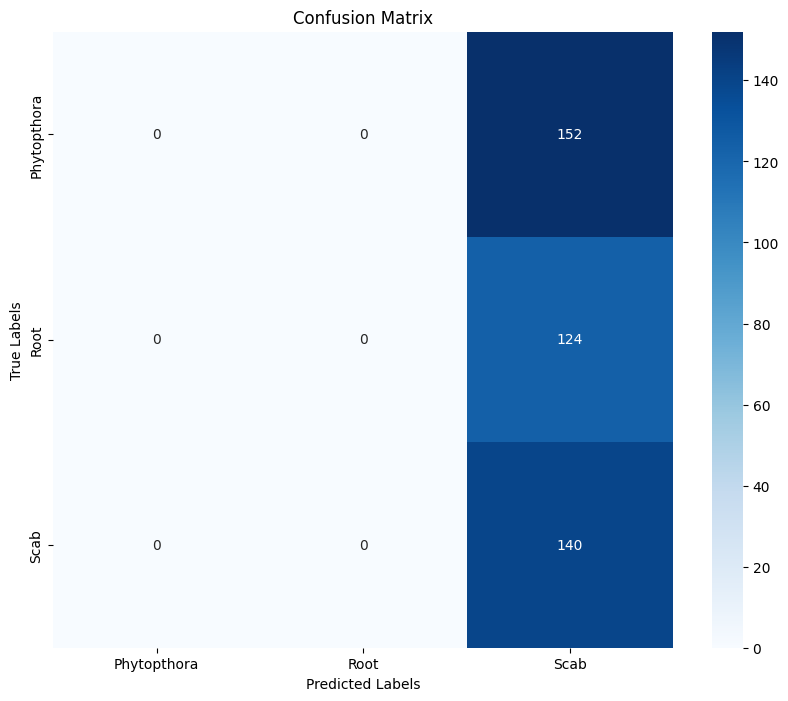

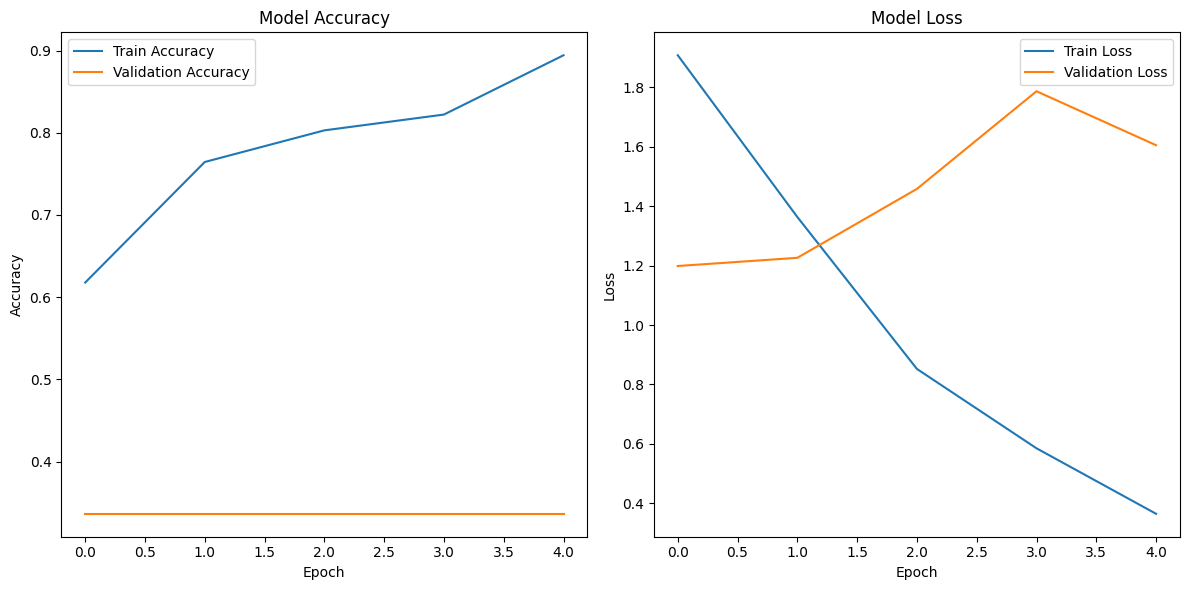

In [12]:
# Define paths for training and validation data
train_data_path = '/content/drive/MyDrive/SDP_Project_Dataset/Fruit_Disease_Dataset'
validation_data_path = '/content/drive/MyDrive/SDP_Project_Dataset/Fruit_Disease_Dataset'

# Data augmentation and preprocessing for training and validation sets
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_data_path, target_size=(224, 224), batch_size=32, class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(validation_data_path, target_size=(224, 224), batch_size=32, class_mode='categorical')

# Instantiate and train the classifier
fruit_disease_classifier = FruitDiseaseClassifier(input_shape=(224, 224, 3), num_classes=train_generator.num_classes)

# Build and train the model (You can choose any model)

history = fruit_disease_classifier.train(train_generator, validation_generator, epochs=3)

# Evaluate the model
fruit_disease_classifier.evaluate(validation_generator)

# Plot training history
fruit_disease_classifier.plot_training_history(history)

# Display classification report and confusion matrix
fruit_disease_classifier.classification_report(validation_generator)


